# Multi Head Attention

<img src="images/transformer-architecture-1.png" width="500">

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

![diagram](images/attention-head-diagram.png)

The `sequence_length` is the length of the input sequence. Typically, this would be set to the maximum sequence length so that all of the input vectors are of fixed size. Other input sequences with lengths less than the maximum sequence length are padded.

The `batch_size` is going to help with parallel processing and training of the GPU. In this example, we will keep it simple and set the batch size to 1.

The `input_dim` is the input vector dimension of every word that goes into the attention unit.

The `d_model` is the output vector dimension of every word from the attention unit.

We are generating a randomly sampled input `x` because we are not creating the positional encoding in the input phase right now. 

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512

x = torch.randn((batch_size, sequence_length, input_dim))
x.size()

torch.Size([1, 4, 512])

Now, we will be mapping the input from the input dimension to the output dimension multiplied by 3. This is done to create the query, key and value matrices, all concatenated and having all of the attention heads which we will split up later.

In [3]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [4]:
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

To get an idea what kind of values we are getting, we can plot the distribution of the `qkv` matrix. Since, we randomly sampled from a normal distribution for our input `x`, we should expect the values to be normally distributed.

**Note:** Do note that the distribution of values in the `qkv` matrix is going to be very different depending on how we generate the data, the inputs and the positional encodings.

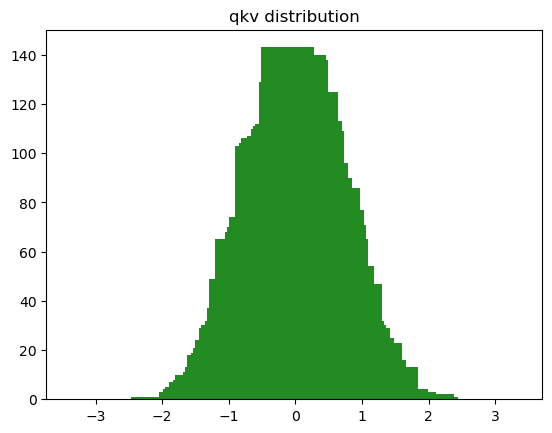

In [5]:
import matplotlib.pyplot as plt

y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align="center", color=["forestgreen"])
plt.title("qkv distribution")
plt.show()

Now, we reshape our `qkv` matrix to break down the last dimension of 1536 into a product of `num_heads` and 3 $\times$ the `head_dim`.

`num_heads` refers to the number of attention heads that will make up our attention unit.

`head_dim` refers to the number of dimensions per attention head.

**Note:** We multiply the `head_dim` by 3 because the `qkv` matrix is a combination of the query, key and value matrices.

In [6]:
num_heads = 8
head_dim = d_model // num_heads  # 64
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

In [7]:
qkv = qkv.permute(0, 2, 1, 3)  # [batch_size, num_heads,sequence_length, 3 * head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

We perform the above permutation because it is easier to perform parallel operations on the last two dimensions.

In [8]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self Attention for Multiple Heads

For a single head:

\begin{align}

\text{self attention} = \text{softmax}(\frac{Q·K^{T}}{\sqrt{d_{k}}} + M) \nonumber

\end{align}

\begin{align}

\text{new } V = \text{self attention}·V \nonumber
 
\end{align}

**Note:** You have to use the `torch.transpose()` function because `k` is a matrix (more specifically, a 4-dimensional tensor) and not simply a 2-dimensional matrix.

In [9]:
d_k = q.size()[-1]  # 64
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [10]:
# The ordering does not matter
(k.transpose(-1, -2) == k.transpose(-2, -1)).all()

tensor(True)

In [11]:
mask = torch.full(scaled.size(), float("-inf"))
mask = torch.triu(mask, diagonal=1)
mask[0][1]  # Mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [12]:
(scaled + mask)[0][1]

tensor([[ 0.1473,    -inf,    -inf,    -inf],
        [ 0.2594,  0.1353,    -inf,    -inf],
        [-0.5262, -0.2408,  0.2090,    -inf],
        [ 0.4084,  0.0936,  0.3839,  0.4296]], grad_fn=<SelectBackward0>)

In [13]:
scaled += mask

In [14]:
attention = F.softmax(scaled, dim=-1)
attention.shape

torch.Size([1, 8, 4, 4])

In [15]:
attention[0][1]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5310, 0.4690, 0.0000, 0.0000],
        [0.2264, 0.3012, 0.4723, 0.0000],
        [0.2683, 0.1958, 0.2618, 0.2740]], grad_fn=<SelectBackward0>)

In [16]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

## Function

The `scaled_dot_product` below is the same one as the [previous section](1-Self_Attention_for_Transformers_Neural_Network.ipynb) except for the `k.transpose(-2, -1)` where now, we are transposing a higher dimensional vector.

In [17]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

### Encoder

In [18]:
values, attention = scaled_dot_product(q, k, v)

In [19]:
attention.shape

torch.Size([1, 8, 4, 4])

In [20]:
attention[0][1]

tensor([[0.2273, 0.3466, 0.2344, 0.1917],
        [0.2949, 0.2605, 0.1682, 0.2764],
        [0.1710, 0.2274, 0.3566, 0.2450],
        [0.2683, 0.1958, 0.2618, 0.2740]], grad_fn=<SelectBackward0>)

### Decoder

In [21]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [22]:
attention.shape

torch.Size([1, 8, 4, 4])

In [23]:
attention[0][1]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5310, 0.4690, 0.0000, 0.0000],
        [0.2264, 0.3012, 0.4723, 0.0000],
        [0.2683, 0.1958, 0.2618, 0.2740]], grad_fn=<SelectBackward0>)

Now, we have the value matrix for every single head (i.e. 8) for every single word (i.e. 4) which are 64-dimensional vectors. 

In [24]:
values.size()

torch.Size([1, 8, 4, 64])

Then, we concatenate all of the heads together. For 8 heads, we are now going to have 512-dimensional vectors (because 8 x 64) which is exactly the input dimension.

In [25]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.shape

torch.Size([1, 4, 512])

For these heads to communicate with each another on the information they've learned, we are going to pass the matrix through a linear layer which is simply a feed forward layer of 512 input dimension and 512 output dimension.

In [26]:
linear_layer = nn.Linear(d_model, d_model)
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])

Now this output matrix is going to be much more context aware than the input matrix was.

## Class

In [27]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, _ = x.size()
        # [batch_size, sequence_length, input_dim]
        print(f"x.size(): {x.size()}")

        qkv = self.qkv_layer(x)
        # [batch_size, sequence_length, 3 * d_model]
        print(f"qkv.size(): {qkv.size()}")

        qkv = qkv.reshape(
            batch_size, sequence_length, self.num_heads, 3 * self.head_dim
        )
        # [batch_size, sequence_length, num_heads, 3 * head_dim] where 3 * num_heads * head_dim = 3 * d_model
        print(f"qkv.size(): {qkv.size()}")

        qkv = qkv.permute(0, 2, 1, 3)
        # [batch_size, num_heads, sequence_length, 3 * head_dim]
        print(f"qkv.size(): {qkv.size()}")

        q, k, v = qkv.chunk(3, dim=-1)
        # Each are [batch_size, num_heads, sequence_length, head_dim]
        print(f"q.size(): {q.size()}, k.size(): {k.size()}, v.size(): {v.size()}")

        values, attention = scaled_dot_product(q, k, v, mask=mask)
        # values.size() -> [batch_size, num_heads, sequence_length, head_dim], attention.size() -> [batch_size, num_heads, sequence_length, sequence_length]
        print(f"values.size(): {values.size()}, attention.size(): {attention.size()}")

        values = values.reshape(
            batch_size, sequence_length, self.num_heads * self.head_dim
        )
        # [batch_size, sequence_length, num_heads * head_dim]
        print(f"values.size(): {values.size()}")

        out = self.linear_layer(values)
        # [batch_size, sequence_length, num_heads * head_dim]
        print(f"out.size(): {out.size()}")

        return out

## Input

In [28]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))

model = MultiHeadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q.size(): torch.Size([30, 8, 5, 64]), k.size(): torch.Size([30, 8, 5, 64]), v.size(): torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]), attention.size(): torch.Size([30, 8, 5, 5])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
